In [1]:
import torch as th
from sb3_contrib import TQC
from active_critic.utils.gym_utils import make_policy_dict, make_dummy_vec_env
from stable_baselines3.common.torch_layers import CombinedExtractor
from stable_baselines3.common.evaluation import evaluate_policy
import gym
import numpy as np
from gym import Env

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [2]:
seq_env, expert = make_dummy_vec_env(name='reach', seq_len=100)
policy_kwargs = dict(n_critics=2, n_quantiles=25, net_arch=[512,512,512])

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [3]:
tqc_learner = TQC(policy='MlpPolicy',env=seq_env, top_quantiles_to_drop_per_net=2, verbose=1, policy_kwargs=policy_kwargs)

Using cpu device


/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
tqc_learner.learn(30000, log_interval=float('inf'))

KeyboardInterrupt: 

In [ ]:
seq_env.envs[0].reset_count

101

In [ ]:
import torch as th

/home/hendrik/anaconda3/envs/ac/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
obsv = seq_env.reset()
rews = []
success = []
actions = []
for i in range(10000):
    action = tqc_learner.policy.predict(obsv[0])
    actions.append(action[0])
    obsv, rew, done, info = seq_env.step(action)
    rews.append(rew)
    if done[0]:
        success.append(info[0]['success'])
        break

In [ ]:
actions = np.array(actions)
actions.shape

(100, 4)

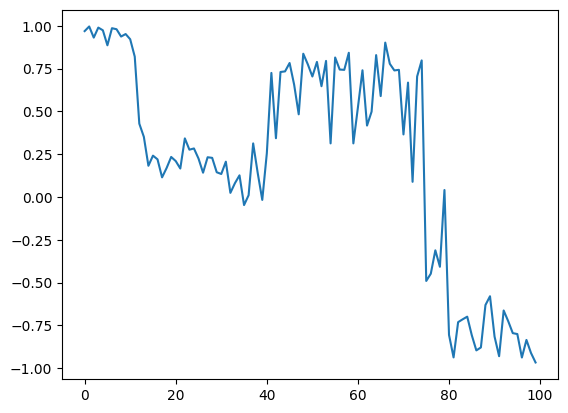

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
ax.plot(np.arange(len(rews)), actions[:,3])

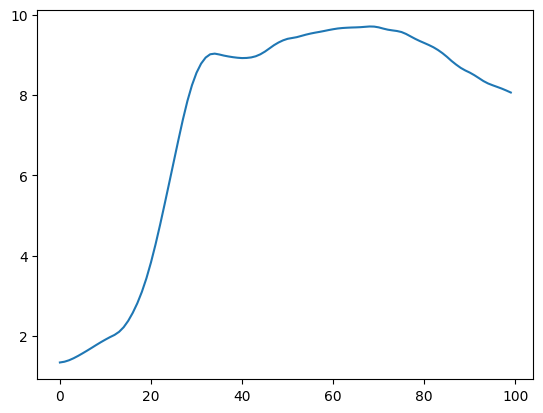

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
ax.plot(np.arange(len(rews)), np.array(rews))

In [ ]:
rews = np.array(rews)
success = np.array(success)
print(f'rew: {rews.mean()}')
print(f'success: {success.mean()}')


rew: 7.4088239669799805
success: 0.0


In [ ]:
success

array([0.])